In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import gc
import lightgbm as lgb
import optuna
%matplotlib inline
print("Libraries imported")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Libraries imported
/kaggle/input/cat-boost-model-ensemble/reg_catb_to_ensemble
/kaggle/input/widsdatathon2023/train_data.csv
/kaggle/input/widsdatathon2023/test_data.csv
/kaggle/input/widsdatathon2023/sample_solution.csv
/kaggle/input/cat-boost-model/reg_catb_RMSE_test_1.015
/kaggle/input/bankadditionalfullcsv/bank-additional-full.csv


In [4]:
from scipy import stats

# Loading data

## Load the data of train and test set

In [5]:
cc_train = pd.read_csv('/kaggle/input/widsdatathon2023/train_data.csv')
cc_test = pd.read_csv('/kaggle/input/widsdatathon2023/test_data.csv')
cc_sample = pd.read_csv('/kaggle/input/widsdatathon2023/sample_solution.csv')

## Reduce the memory usage of the dataset
[Reduce DF size](https://www.kaggle.com/competitions/widsdatathon2023/discussion/376649)

In [6]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [7]:
cc_train = reduce_mem_usage(cc_train)

Mem. usage decreased to 352.24 Mb (50.1% reduction)


# Exploratary Data Analysis

## Overview of the dataset

In [8]:
# Save into a new dataset
train_df = cc_train.copy()
test_df = cc_test.copy()

In [7]:
print(train_df.shape)
print(test_df.shape)

(375734, 246)
(31354, 245)


## Visualise the time gap between the train and the test data

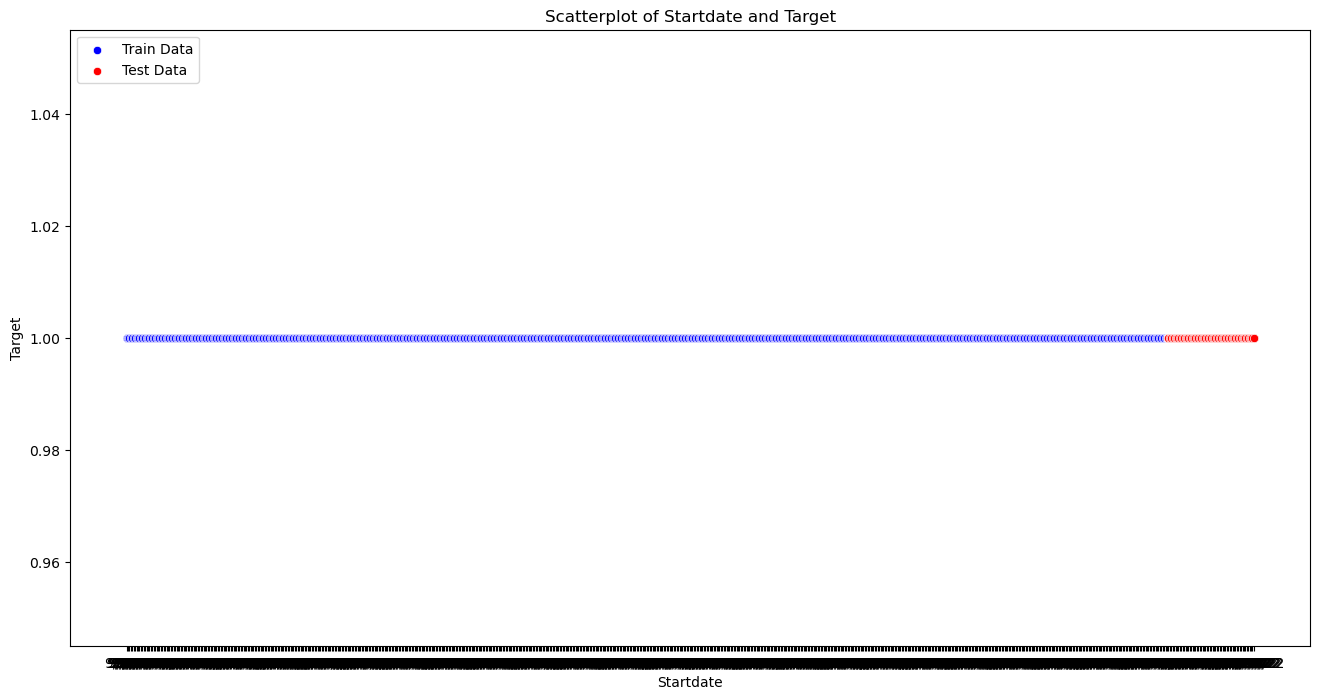

In [8]:
# create a scatterplot using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16, 8))
sb.scatterplot(x=train_df.startdate, y=1, color='blue', label='Train Data', ax=ax)
sb.scatterplot(x=test_df.startdate, y=1, color='red', label='Test Data', ax=ax)

# add labels and a title to the plot
ax.set_title('Scatterplot of Startdate and Target')
ax.set_xlabel('Startdate')
ax.set_ylabel('Target')
ax.legend(loc='upper left')

# display the plot
plt.show()

In [9]:
train_df["startdate"].describe()

count     375734
unique       731
top       9/1/14
freq         514
Name: startdate, dtype: object

In [10]:
print("train date from {} to {}.".format(train_df["startdate"].unique()[0],  train_df["startdate"].unique()[-1]))

train date from 9/1/14 to 8/31/16.


In [11]:
test_df["startdate"].describe()

count       31354
unique         61
top       11/1/22
freq          514
Name: startdate, dtype: object

In [12]:
print("test date from {} to {}.".format(test_df["startdate"].unique()[0],  test_df["startdate"].unique()[-1]))

test date from 11/1/22 to 12/31/22.


**Based on the graph above the train data was from 2014 - 2016 and the test data is from 2022. There is a big time gap between the train and test data.**

## Analyising the distribution of values in both the train and test dataset

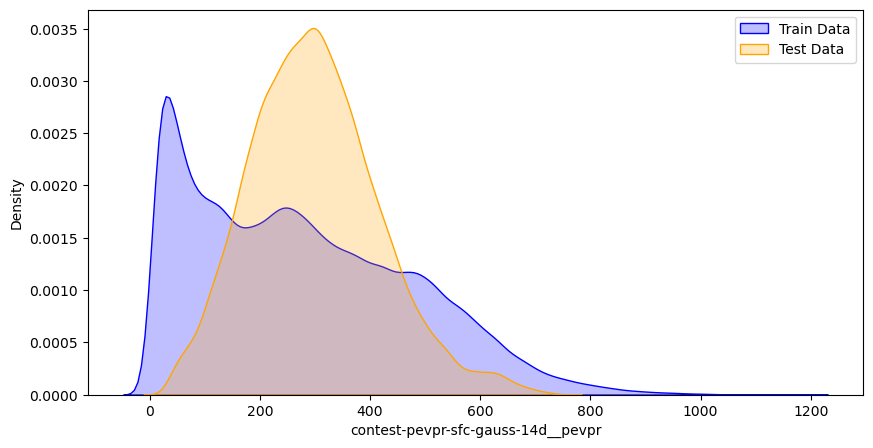

In [13]:
def train_test_dist(train, test):
    fig, ax = plt.subplots(figsize = (10, 5))
    sb.kdeplot(data=train,  color='blue', fill=True, ax=ax, label="Train Data")
    sb.kdeplot(data=test, color='orange', fill=True, ax=ax, label="Test Data")
    plt.legend()
    plt.show()
    
train_target = cc_train['contest-pevpr-sfc-gauss-14d__pevpr']
test_target = cc_test['contest-pevpr-sfc-gauss-14d__pevpr']
train_test_dist(train_target, test_target)

## Visualizing the target variable
> contest-tmp2m-14d__tmp2m

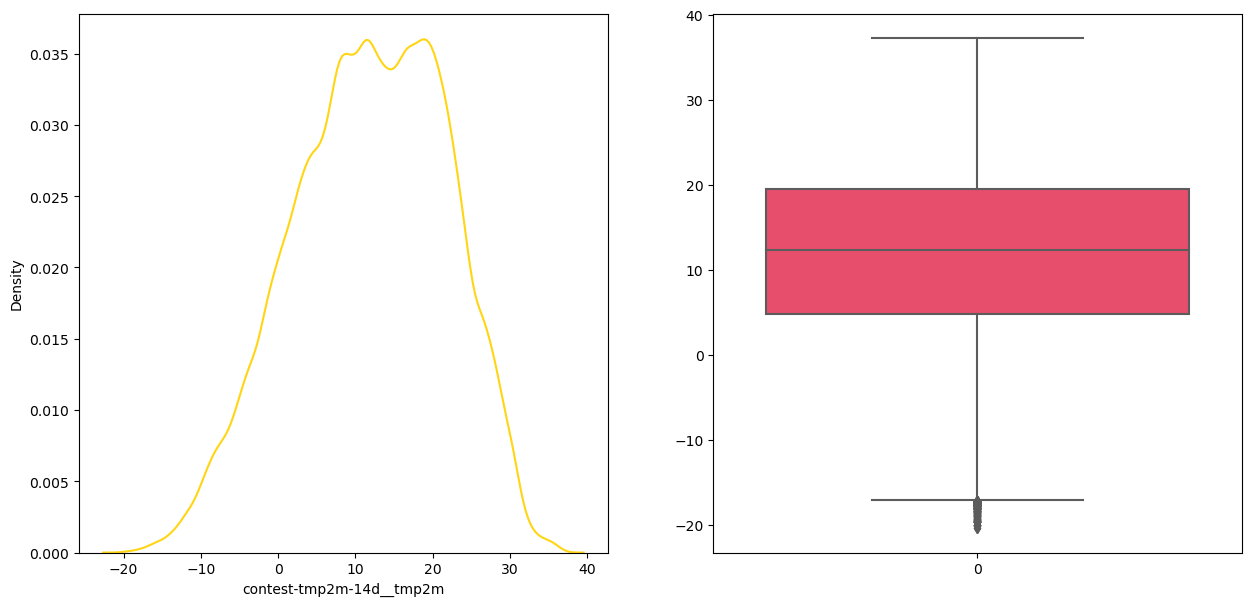

In [14]:
def target_var_visualized():
  plt.figure(figsize=(15,7))
  plt.subplot(121)
  sb.kdeplot(cc_train['contest-tmp2m-14d__tmp2m'], color = "#ffd514")
  plt.subplot(122)
  sb.boxplot(data=cc_train['contest-tmp2m-14d__tmp2m'], color = "#ff355d")
target_var_visualized()

## Displaying the distribution of the target variable in the train and test

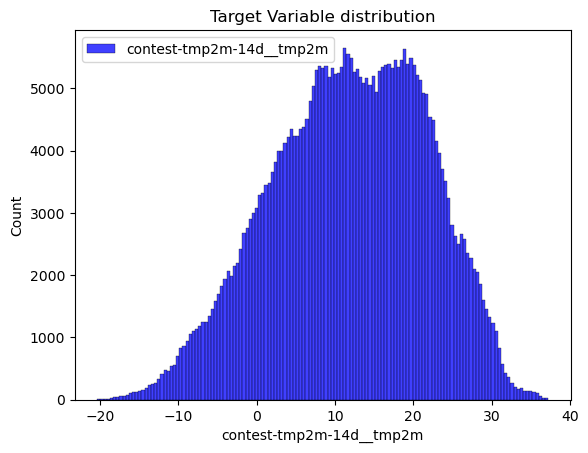

In [15]:
def histogram_plot(data, label, title):
    sb.histplot(data, color='blue', label=label)
    plt.legend()
    plt.title(title)
    plt.show()
histogram_plot(data=cc_train['contest-tmp2m-14d__tmp2m'], label="contest-tmp2m-14d__tmp2m", title="Target Variable distribution")

**The target variable is not in the test dataset**

# Data Preprocessing

## Location features

In [9]:
def location_feature(train, test):
    # Reference: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14
    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)
    
    train_and_test = pd.concat([train, test], axis=0)
    train_and_test['loc_group'] = train_and_test.groupby(['lat', 'lon']).ngroup()
    print(f'{train_and_test.loc_group.nunique()} unique locations')
    
    train = train_and_test.iloc[:len(train)]
    test = train_and_test.iloc[len(train):].drop(target, axis=1)
    
    return train, test

## Encoding categorical variables

In [10]:
def cat_encode(train, test):
    # encoding the categorical feature in the train and test data set
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[['climateregions__climateregion']])
    test_encoded = ohe.transform(test[['climateregions__climateregion']])
    
    train = train.drop(['climateregions__climateregion'], axis=1)
    test = test.drop(['climateregions__climateregion'], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out(['climateregions__climateregion']))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

In [11]:
def categorical_label_encode(train, test, cat_cols):
    le = LabelEncoder()
    for col in cat_cols:
        train[col] = le.fit_transform(train[[col]])
        test[col] = le.transform(test[[col]])
    return train, test

## Two ways to fill na: By Mean or Interpolation

In [12]:
def fill_na_rows(dataset):
    # Find the columns with missing values
    columns_with_missing_values = dataset.columns[dataset.isnull().any()].tolist()
    
    # Impute the missing values with the mean value of that column
    for col in columns_with_missing_values:
        dataset[col].fillna(dataset[col].mean(), inplace=True)
        
    return dataset

In [13]:
def linear_interpolation_by_level(df, feature):
    
    """Function linear interpolation for the dataset considering the levels of a categorical feature"""
    
    #Initializing dataframe
    imputation_val = pd.DataFrame()
    #List of all locations
    level_list = df[feature].unique().tolist()
    
    #Function
    for i in level_list:
        #Dataframe
        dataf = df[df[feature]==i].interpolate(method='linear')
        #Appending
        imputation_val = pd.concat([imputation_val,dataf])
    
    return imputation_val

## Create new features on datetime

In [14]:
def create_new_feat(dataset):
    dataset['year']=pd.DatetimeIndex(dataset['startdate']).year 
    dataset['month']=pd.DatetimeIndex(dataset['startdate']).month 
    dataset['day']=pd.DatetimeIndex(dataset['startdate']).day
    return dataset

## Transformation

In [15]:
def yeojohnson_transform(train_data, test_data):
    """yeojohnson transformation for all train and test dataset
    Note that: you must drop out 'index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion'
    before using yeojohnson transformation"""
    
    # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Loop over each column in the training set
    lambda_values = {}
    transformed_train_data = pd.DataFrame()
    for col in numeric_cols:
        # Apply yeojohnson transformation on training set
        transformed_col, lambda_value = stats.yeojohnson(train_data[col])
        # Store the lambda value for each column
        lambda_values[col] = lambda_value
        # Store the transformed column in a new DataFrame
        transformed_train_data[col] = transformed_col

    # Apply yeojohnson transformation on test set using lambda values from training set
    transformed_test_data = pd.DataFrame()
    for col in numeric_cols:
        transformed_test_data[col] = stats.yeojohnson(test_data[col], lambda_values[col])
        
    return transformed_train_data, transformed_test_data

In [16]:
def MinMaxScaler_transform(train_data, test_data):
        # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Apply MinMaxScaler on training set
    scaler = MinMaxScaler()
    scaler.fit(train_data[numeric_cols])
    transformed_train_data = pd.DataFrame(scaler.transform(train_data[numeric_cols]), columns=numeric_cols)

    # Apply MinMaxScaler on test set using parameters from training set
    transformed_test_data = pd.DataFrame(scaler.transform(test_data[numeric_cols]), columns=numeric_cols)
    
    return transformed_train_data, transformed_test_data

In [17]:
def StandardScaler_transform(train_data, test_data):
    # Get the numeric columns
    numeric_cols = train_data.select_dtypes(include="number").columns.tolist()

    # Apply StandardScaler on training set
    scaler = StandardScaler()
    scaler.fit(train_data[numeric_cols])
    transformed_train_data = pd.DataFrame(scaler.transform(train_data[numeric_cols]), columns=numeric_cols)

    # Apply StandardScaler on test set using parameters from training set
    transformed_test_data = pd.DataFrame(scaler.transform(test_data[numeric_cols]), columns=numeric_cols)
    return transformed_train_data, transformed_test_data

In [18]:
def feature_scale(train, test):
    scaler = MinMaxScaler()
    train_ = scaler.fit_transform(train)
    test_ = scaler.transform(test)
    train = pd.DataFrame(train_, columns = train.columns)
    test = pd.DataFrame(test_, columns = test.columns)
    return train, test

In [19]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [20]:
target="contest-tmp2m-14d__tmp2m"

In [21]:
def feature_engineering(origin_train, origin_test):
    train, test = location_feature(origin_train, origin_test)
    
    train = linear_interpolation_by_level(train, "lat")
    #train = fill_na_rows(train)

    train = create_new_feat(train)
    test = create_new_feat(test)

    train, test =  categorical_label_encode(train, test, cat_cols=['climateregions__climateregion'])
   
    #train, test = cat_encode(train, test)
    
    #irrelevant_cols = ['index', 'startdate','contest-tmp2m-14d__tmp2m', 'climateregions__climateregion']
    #features = [col for col in train.columns if col not in irrelevant_cols]

    to_drop = identify_correlated(train.copy(), threshold=.85)
    drop_cols = ['index', 'startdate', target]
    drop_cols.extend(to_drop)
    features = [col for col in train.columns if col not in drop_cols]
   
    X = train[features]
    X_test = test[features]
    y = train['contest-tmp2m-14d__tmp2m']
    
    #X, X_test = StandardScaler_transform(X, X_test)
    #X, X_test = MinMaxScaler_transform(X, X_test)
    X, X_test = feature_scale(X, X_test)
    
    return X, y, X_test

target="contest-tmp2m-14d__tmp2m"

In [22]:
X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())

1026 unique locations


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


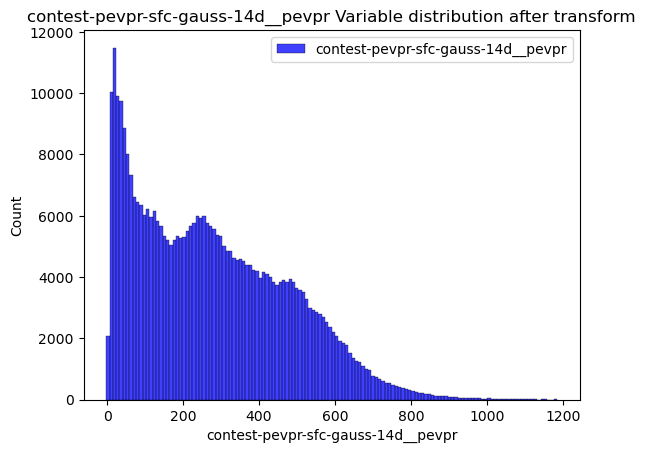

In [28]:
histogram_plot(data=cc_train['contest-pevpr-sfc-gauss-14d__pevpr'], label="contest-pevpr-sfc-gauss-14d__pevpr", title="contest-pevpr-sfc-gauss-14d__pevpr Variable distribution after transform")

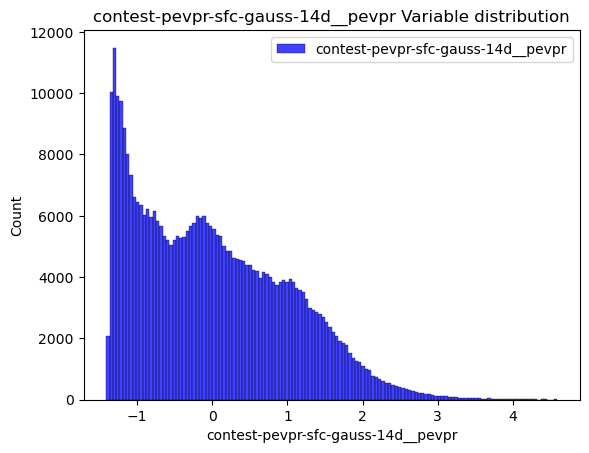

In [29]:
histogram_plot(data=X['contest-pevpr-sfc-gauss-14d__pevpr'], label="contest-pevpr-sfc-gauss-14d__pevpr", title="contest-pevpr-sfc-gauss-14d__pevpr Variable distribution")

## Checking correlation

In [80]:
# plotting correlation heatmap
#dataplot = sb.heatmap(cc_train.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
#plt.show()

In [18]:
train_correlation = cc_train.corr()

In [19]:
train_correlation_thr_below005 = train_correlation[np.abs(train_correlation) < 0.05]

low_correl = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_below005.iloc[i, j]) and train_correlation_thr_below005.iloc[i, j] != 1:
            if train_correlation_thr_below005.columns[i] == "contest-tmp2m-14d__tmp2m" or train_correlation_thr_below005.index[j] == "contest-tmp2m-14d__tmp2m":
                # print(train_correlation_thr_below005.columns[i],train_correlation_thr_below005.index[j], train_correlation_thr_below005.iloc[i, j])
                low_correl.append(train_correlation_thr_below005.columns[i])
                low_correl.append(train_correlation_thr_below005.index[j])
                
low_correl_unique = np.unique(low_correl)

In [20]:
low_correl_unique = list(low_correl_unique)
low_correl_unique.remove("contest-tmp2m-14d__tmp2m")
print(len(low_correl_unique))
low_correl_unique

35


['nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__cfsv2',
 'nmme-prate-56w__nasa',
 'nmme0-prate-34w__cancm30',
 'nmme0-prate-34w__cancm40',
 'nmme0-prate-34w__gfdl0',
 'nmme0-prate-34w__nmme0mean',
 'nmme0-prate-56w__nmme0mean',
 'wind-hgt-10-2010-6',
 'wind-hgt-10-2010-8',
 'wind-hgt-100-2010-3',
 'wind-hgt-100-2010-4',
 'wind-hgt-100-2010-5',
 'wind-hgt-100-2010-8',
 'wind-hgt-850-2010-10',
 'wind-hgt-850-2010-4',
 'wind-hgt-850-2010-8',
 'wind-uwnd-250-2010-10',
 'wind-uwnd-250-2010-13',
 'wind-uwnd-250-2010-14',
 'wind-uwnd-250-2010-6',
 'wind-uwnd-250-2010-7',
 'wind-uwnd-925-2010-17',
 'wind-uwnd-925-2010-19',
 'wind-uwnd-925-2010-3',
 'wind-vwnd-250-2010-15',
 'wind-vwnd-250-2010-20',
 'wind-vwnd-250-2010-6',
 'wind-vwnd-250-2010-8',
 'wind-vwnd-925-2010-11',
 'wind-vwnd-925-2010-14',
 'wind-vwnd-925-2010-17',
 'wind-vwnd-925-2010-6',
 'wind-vwnd-925-2010-8']

In [21]:
train_correlation_thr_099 = train_correlation[np.abs(train_correlation) > 0.99]
train_correlation_thr_099

index       lat  lon  \
index                               1.000000  0.995633  NaN   
lat                                 0.995633  1.000000  NaN   
lon                                      NaN       NaN  1.0   
contest-pevpr-sfc-gauss-14d__pevpr       NaN       NaN  NaN   
nmme0-tmp2m-34w__cancm30                 NaN       NaN  NaN   
...                                      ...       ...  ...   
wind-vwnd-925-2010-16                    NaN       NaN  NaN   
wind-vwnd-925-2010-17                    NaN       NaN  NaN   
wind-vwnd-925-2010-18                    NaN       NaN  NaN   
wind-vwnd-925-2010-19                    NaN       NaN  NaN   
wind-vwnd-925-2010-20                    NaN       NaN  NaN   

                                    contest-pevpr-sfc-gauss-14d__pevpr  \
index                                                              NaN   
lat                                                                NaN   
lon                                                                NaN   
contest-pevpr-sfc-gauss-14d__pevpr                                 1.0   
nmme0-tmp2m-34w__cancm30                                           NaN   
...                                                                ...   
wind-vwnd-925-2010-16                                              NaN   
wind-vwnd-925-2010-17                                              NaN   
wind-vwnd-925-2010-18                                              NaN   
wind-vwnd-925-2010-19                                              NaN   
wind-vwnd-925-2010-20                                              NaN   

                                    nmme0-tmp2m-34w__cancm30  \
index                                                    NaN   
lat                                                      NaN   
lon                                                      NaN   
contest-pevpr-sfc-gauss-14d__pevpr                       NaN   
nmme0-tmp2m-34w__cancm30                                 1.0   
...                                                      ...   
wind-vwnd-925-2010-16                                    NaN   
wind-vwnd-925-2010-17                                    NaN   
wind-vwnd-925-2010-18                                    NaN   
wind-vwnd-925-2010-19                                    NaN   
wind-vwnd-925-2010-20                                    NaN   

                                    nmme0-tmp2m-34w__cancm40  \
index                                                    NaN   
lat                                                      NaN   
lon                                                      NaN   
contest-pevpr-sfc-gauss-14d__pevpr                       NaN   
nmme0-tmp2m-34w__cancm30                                 NaN   
...                                                      ...   
wind-vwnd-925-2010-16                                    NaN   
wind-vwnd-925-2010-17                                    NaN   
wind-vwnd-925-2010-18                                    NaN   
wind-vwnd-925-2010-19                                    NaN   
wind-vwnd-925-2010-20                                    NaN   

                                    nmme0-tmp2m-34w__ccsm30  \
index                                                   NaN   
lat                                                     NaN   
lon                                                     NaN   
contest-pevpr-sfc-gauss-14d__pevpr                      NaN   
nmme0-tmp2m-34w__cancm30                                NaN   
...                                                     ...   
wind-vwnd-925-2010-16                                   NaN   
wind-vwnd-925-2010-17                                   NaN   
wind-vwnd-925-2010-18                                   NaN   
wind-vwnd-925-2010-19                                   NaN   
wind-vwnd-925-2010-20                                   NaN   

                                    nmme0-tmp2m-34w__ccsm40  \
index                              

In [22]:
features_to_drop = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_099.iloc[i, j]) and train_correlation_thr_099.iloc[i, j] != 1:
            if train_correlation_thr_099.columns[i] != "contest-tmp2m-14d__tmp2m" and train_correlation_thr_099.index[j] != "contest-tmp2m-14d__tmp2m":
                # print(train_correlation_thr_099.columns[i],train_correlation_thr_099.index[j], train_correlation_thr_099.iloc[i, j])
                features_to_drop.append(train_correlation_thr_099.columns[i])
                features_to_drop.append(train_correlation_thr_099.index[j])
features_to_drop_unique = np.unique(features_to_drop)

In [23]:
features_to_drop_unique

array(['cancm30', 'ccsm40', 'cfsv20', 'gfdlflora0', 'gfdlflorb0', 'index',
       'lat', 'nmme-prate-34w__nmmemean', 'nmme-prate-56w__nmmemean',
       'nmme-tmp2m-34w__cancm3', 'nmme-tmp2m-34w__cancm4',
       'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2',
       'nmme-tmp2m-34w__gfdl', 'nmme-tmp2m-34w__gfdlflora',
       'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa',
       'nmme-tmp2m-34w__nmmemean', 'nmme-tmp2m-56w__cancm3',
       'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm4',
       'nmme-tmp2m-56w__cfsv2', 'nmme-tmp2m-56w__gfdl',
       'nmme-tmp2m-56w__gfdlflora', 'nmme-tmp2m-56w__gfdlflorb',
       'nmme-tmp2m-56w__nasa', 'nmme-tmp2m-56w__nmmemean',
       'nmme0-tmp2m-34w__cancm30', 'nmme0-tmp2m-34w__ccsm40',
       'nmme0-tmp2m-34w__cfsv20', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__gfdlflorb0', 'nmme0-tmp2m-34w__nmme0mean',
       'nmme0mean'], dtype='<U27')

In [24]:
len(features_to_drop_unique)

34

In [25]:
train_correlation_thr_08 = train_correlation[np.abs(train_correlation) > 0.8]
train_correlation_thr_08

index       lat  lon  \
index                               1.000000  0.995633  NaN   
lat                                 0.995633  1.000000  NaN   
lon                                      NaN       NaN  1.0   
contest-pevpr-sfc-gauss-14d__pevpr       NaN       NaN  NaN   
nmme0-tmp2m-34w__cancm30                 NaN       NaN  NaN   
...                                      ...       ...  ...   
wind-vwnd-925-2010-16                    NaN       NaN  NaN   
wind-vwnd-925-2010-17                    NaN       NaN  NaN   
wind-vwnd-925-2010-18                    NaN       NaN  NaN   
wind-vwnd-925-2010-19                    NaN       NaN  NaN   
wind-vwnd-925-2010-20                    NaN       NaN  NaN   

                                    contest-pevpr-sfc-gauss-14d__pevpr  \
index                                                              NaN   
lat                                                                NaN   
lon                                                                NaN   
contest-pevpr-sfc-gauss-14d__pevpr                                 1.0   
nmme0-tmp2m-34w__cancm30                                           NaN   
...                                                                ...   
wind-vwnd-925-2010-16                                              NaN   
wind-vwnd-925-2010-17                                              NaN   
wind-vwnd-925-2010-18                                              NaN   
wind-vwnd-925-2010-19                                              NaN   
wind-vwnd-925-2010-20                                              NaN   

                                    nmme0-tmp2m-34w__cancm30  \
index                                                    NaN   
lat                                                      NaN   
lon                                                      NaN   
contest-pevpr-sfc-gauss-14d__pevpr                       NaN   
nmme0-tmp2m-34w__cancm30                                 1.0   
...                                                      ...   
wind-vwnd-925-2010-16                                    NaN   
wind-vwnd-925-2010-17                                    NaN   
wind-vwnd-925-2010-18                                    NaN   
wind-vwnd-925-2010-19                                    NaN   
wind-vwnd-925-2010-20                                    NaN   

                                    nmme0-tmp2m-34w__cancm40  \
index                                                    NaN   
lat                                                      NaN   
lon                                                      NaN   
contest-pevpr-sfc-gauss-14d__pevpr                       NaN   
nmme0-tmp2m-34w__cancm30                            0.989678   
...                                                      ...   
wind-vwnd-925-2010-16                                    NaN   
wind-vwnd-925-2010-17                                    NaN   
wind-vwnd-925-2010-18                                    NaN   
wind-vwnd-925-2010-19                                    NaN   
wind-vwnd-925-2010-20                                    NaN   

                                    nmme0-tmp2m-34w__ccsm30  \
index                                                   NaN   
lat                                                     NaN   
lon                                                     NaN   
contest-pevpr-sfc-gauss-14d__pevpr                      NaN   
nmme0-tmp2m-34w__cancm30                           0.984421   
...                                                     ...   
wind-vwnd-925-2010-16                                   NaN   
wind-vwnd-925-2010-17                                   NaN   
wind-vwnd-925-2010-18                                   NaN   
wind-vwnd-925-2010-19                                   NaN   
wind-vwnd-925-2010-20                                   NaN   

                                    nmme0-tmp2m-34w__ccsm40  \
index                              

In [26]:
features_have_to_keep = []
for i in range(244):
    for j in range(244):
        if not np.isnan(train_correlation_thr_08.iloc[i, j]) and train_correlation_thr_08.iloc[i, j] != 1:
            if train_correlation_thr_08.columns[i] == "contest-tmp2m-14d__tmp2m" or train_correlation_thr_08.index[j] == "contest-tmp2m-14d__tmp2m":
                #print(train_correlation_thr_08.columns[i],train_correlation_thr_08.index[j], train_correlation_thr_08.iloc[i, j])
                features_have_to_keep.append(train_correlation_thr_08.columns[i])
                features_have_to_keep.append(train_correlation_thr_08.index[j])
features_have_to_keep_unique = np.unique(features_have_to_keep)

In [27]:
features_have_to_keep_unique

array(['contest-pevpr-sfc-gauss-14d__pevpr', 'contest-tmp2m-14d__tmp2m',
       'contest-wind-h100-14d__wind-hgt-100',
       'contest-wind-h500-14d__wind-hgt-500', 'nmme-tmp2m-34w__cancm3',
       'nmme-tmp2m-34w__cancm4', 'nmme-tmp2m-34w__ccsm3',
       'nmme-tmp2m-34w__ccsm4', 'nmme-tmp2m-34w__cfsv2',
       'nmme-tmp2m-34w__gfdl', 'nmme-tmp2m-34w__gfdlflora',
       'nmme-tmp2m-34w__gfdlflorb', 'nmme-tmp2m-34w__nasa',
       'nmme-tmp2m-34w__nmmemean', 'nmme-tmp2m-56w__cancm3',
       'nmme-tmp2m-56w__cancm4', 'nmme-tmp2m-56w__ccsm3',
       'nmme-tmp2m-56w__ccsm4', 'nmme-tmp2m-56w__cfsv2',
       'nmme-tmp2m-56w__gfdl', 'nmme-tmp2m-56w__gfdlflora',
       'nmme-tmp2m-56w__gfdlflorb', 'nmme-tmp2m-56w__nasa',
       'nmme-tmp2m-56w__nmmemean', 'nmme0-tmp2m-34w__cancm30',
       'nmme0-tmp2m-34w__cancm40', 'nmme0-tmp2m-34w__ccsm30',
       'nmme0-tmp2m-34w__ccsm40', 'nmme0-tmp2m-34w__cfsv20',
       'nmme0-tmp2m-34w__gfdl0', 'nmme0-tmp2m-34w__gfdlflora0',
       'nmme0-tmp2m-34w__gfd

In [28]:
len(features_have_to_keep_unique)

38

In [29]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
features_to_keep = intersection(features_to_drop_unique, features_have_to_keep_unique)

features_to_drop_v1 = []
for feat in features_to_drop_unique:
    if feat in features_to_keep:
        continue
    else:
        features_to_drop_v1.append(feat)
        
print(len(features_to_drop_v1))
features_to_drop_v1.remove("index")
features_to_drop_v1

10


['cancm30',
 'ccsm40',
 'cfsv20',
 'gfdlflora0',
 'gfdlflorb0',
 'lat',
 'nmme-prate-34w__nmmemean',
 'nmme-prate-56w__nmmemean',
 'nmme0mean']

In [30]:
for feat in low_correl_unique:
    features_to_drop_v1.append(feat)
print(len(features_to_drop_v1))
features_to_drop_v1

44


['cancm30',
 'ccsm40',
 'cfsv20',
 'gfdlflora0',
 'gfdlflorb0',
 'lat',
 'nmme-prate-34w__nmmemean',
 'nmme-prate-56w__nmmemean',
 'nmme0mean',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__cfsv2',
 'nmme-prate-56w__nasa',
 'nmme0-prate-34w__cancm30',
 'nmme0-prate-34w__cancm40',
 'nmme0-prate-34w__gfdl0',
 'nmme0-prate-34w__nmme0mean',
 'nmme0-prate-56w__nmme0mean',
 'wind-hgt-10-2010-6',
 'wind-hgt-10-2010-8',
 'wind-hgt-100-2010-3',
 'wind-hgt-100-2010-4',
 'wind-hgt-100-2010-5',
 'wind-hgt-100-2010-8',
 'wind-hgt-850-2010-10',
 'wind-hgt-850-2010-4',
 'wind-hgt-850-2010-8',
 'wind-uwnd-250-2010-10',
 'wind-uwnd-250-2010-13',
 'wind-uwnd-250-2010-14',
 'wind-uwnd-250-2010-6',
 'wind-uwnd-250-2010-7',
 'wind-uwnd-925-2010-17',
 'wind-uwnd-925-2010-19',
 'wind-uwnd-925-2010-3',
 'wind-vwnd-250-2010-15',
 'wind-vwnd-250-2010-20',
 'wind-vwnd-250-2010-6',
 'wind-vwnd-250-2010-8',
 'wind-vwnd-925-2010-11',
 'wind-vwnd-925-2010-14',
 'wind-vwnd-925-2010-17',
 'wind-

In [31]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))
print("Dropped features that are highly correlated")

Dropped features that are highly correlated


In [23]:
# Not drop anything
cc_train_reduced = X.copy()
cc_test_reduced = X_test.copy()

In [24]:
X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)
print("Split the dataset for training successfully")

Split the dataset for training successfully


In [25]:
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_test_tts.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 158)    |   Val_shape: (123993, 158)    |   Test_shape: (31354, 158)


# MODELING

In [26]:
import time

## Random Forest

In [96]:
start = time.time()
# Train the Random Forest Regressor
params = {
    'n_estimators': 600,
    'max_depth': 50,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True,
    "random_state": 42
}
regr_rfr = RandomForestRegressor(**params)
regr_rfr.fit(X_train, y_train)
end = time.time()
print("train time: ", end - start)
# make predictions on the test data
y_pred_rfr = regr_rfr.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("RMSE:", rmse)

train time:  2048.175971508026
RMSE: 0.38611355721191837


In [ ]:
"""start = time.time()
# Train the Random Forest Regressor
params = {
    'n_estimators': 700,
    'max_depth': 42,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True,
    "random_state": 42
}
regr_rfr = RandomForestRegressor(**params)
regr_rfr.fit(X_train, y_train)
end = time.time()
print("train time: ", end - start)
# make predictions on the test data
y_pred_rfr = regr_rfr.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print("RMSE:", rmse)
"""

In [97]:
cc_test_pred = regr_rfr.predict(cc_test_reduced)

In [98]:
cc_test_copy = cc_test.copy()

In [99]:
cc_test_copy[target] = cc_test_pred
#cc_test_copy[[target,"index"]].to_csv("rfrpredictions_mxb_250223_version2_notune.csv",index = False)

## CatBoost

In [ ]:
#reg_catb  = CatBoostRegressor(n_estimators= 2000, eval_metric= 'RMSE', learning_rate=0.1, random_seed= 1234)

#reg_catb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test_tts, y_test)],verbose=100)

In [ ]:
#X_test_prediction_cat = reg_catb.predict(X_test_tts)

In [ ]:
#error on test dataset

#score = np.sqrt(mean_squared_error(y_test, X_test_prediction_cat))
#print(f'RMSE Score on Test set: {score:0.2f}')

In [ ]:
#cc_test_pred_cat = reg_catb.predict(cc_test_reduced)

In [ ]:
#cc_test_copy_cat[target] = cc_test_pred_cat
#cc_test_copy_cat[[target,"index"]].to_csv("cat_predictions_mxb_250223_version1.csv",index = False)

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 150)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    #min_sample_split = trial.suggest_int('min_sample_split', 2, 10)
    #min_sample_leaf = trial.suggest_int('min_sample_leaf', 2, 10)
    regr_rfr = RandomForestRegressor(n_estimators = n_estimators,
                                     max_depth = max_depth)
                                     #min_samples_leaf=min_sample_leaf,
                                     #min_samples_split=min_sample_split)
    return sklearn.model_selection.cross_val_score(regr_rfr,
                                                   X,
                                                   y,
                                                   n_jobs=-1,
                                                   cv=5).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

## Lasso

In [50]:
start = time.time()
# Using Lasso
lasso = Lasso(alpha=0.05, random_state=1, max_iter=3000) 
lasso.fit(X_train, y_train) 
end = time.time()
print(abs(start - end))
y_pred_lasso = lasso.predict(X_test_tts) 

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("RMSE:", rmse)

69.97868537902832
RMSE: 1.5028015588455605


In [ ]:
cc_test_pred_lasso = lasso.predict(X_test) 
cc_test_copy[target] = cc_test_pred_lasso 
cc_test_copy[[target,"index"]].to_csv("lassopredictions.csv",index = False)

## lightGBM

In [34]:
def objective(trial):
    params = {
        'boosting_type': 'gbdt', 
        'objective': 'regression', 
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_int('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_int('lambda_l2', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'device_type':'gpu',
        'verbosity': -1,
        'n_estimators': 6000
    }

    reg_lgb = lgb.LGBMRegressor(**params)

    reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])

    y_pred_lgb = reg_lgb.predict(X_test_tts)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value:.5f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')    

[I 2023-02-26 04:37:24,770] A new study created in memory with name: no-name-0d013575-f18a-449a-bce6-57c945d441ce
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=53, reg_alpha=0.0 will be ignored. Current value: lambda_l1=53
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[1]	training's rmse: 9.82656	valid_1's rmse: 9.81956
[2]	training's rmse: 9.78315	valid_1's rmse: 9.77616
[3]	training's rmse: 9.73995	valid_1's rmse: 9.73298
[4]	training's rmse: 9.69698	valid_1's rmse: 9.69003
[5]	training's rmse: 9.65418	valid_1's rmse: 9.64726
[6]	training's rmse: 9.61162	valid_1's rmse: 9.60475
[7]	training's rmse: 9.56924	valid_1's rmse: 9.56239
[8]	training's rmse: 9.52709	valid_1's rmse: 9.52032
[9]	training's rmse: 9.48519	valid_1's rmse: 9.47847
[10]	training's rmse: 9.44347	valid_1's rmse: 9.43683
[11]	training's rmse: 9.40195	valid_1's rmse: 9.39531
[12]	training's rmse: 9.36066	valid_1's rmse: 9.35411
[13]	training's rmse: 9.31959	valid_1's rmse: 9.31307
[14]	training's rmse: 9.27871	valid_1's rmse: 9.27224
[15]	training's rmse: 9.23804	valid_1's rmse: 9.23

[I 2023-02-26 04:42:08,454] Trial 0 finished with value: 0.8058887850318498 and parameters: {'max_depth': 10, 'num_leaves': 17, 'learning_rate': 0.004808323218685455, 'lambda_l1': 53, 'lambda_l2': 20, 'min_child_weight': 7}. Best is trial 0 with value: 0.8058887850318498.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=84, reg_alpha=0.0 will be ignored. Current value: lambda_l1=84
[LightGBM] [Warning] lambda_l2 is set=36, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36
[1]	training's rmse: 9.84092	valid_1's rmse: 9.83392
[2]	training's rmse: 9.81175	valid_1's rmse: 9.80475
[3]	training's rmse: 9.78268	valid_1's rmse: 9.77569
[4]	training's rmse: 9.75373	valid_1's rmse: 9.74677
[5]	training's rmse: 9.72487	valid_1's rmse: 9.71792
[6]	training's rmse: 9.69612	valid_1's rmse: 9.68916
[7]	training's rmse: 9.66748	valid_1's rmse: 9.66054
[8]	training's rmse: 9.63893	valid_1's rmse: 9.632
[9]	training's rmse: 9.61048	valid_1's rmse: 9.60358
[10]	training's rmse: 9.58213	valid_1's rmse: 9.57525
[11]	training's rmse: 9.5539	valid_1's rmse: 9.54704
[12]	training's rmse: 9.52575	valid_1's rmse: 9.51892
[13]	training's rmse: 9.49772	valid_1's rmse: 9.49091
[14]	training's rmse: 9.46978	valid_1's rmse: 9.46299
[15]	training's rmse: 9.44192	valid_1's rmse: 9.43517

[I 2023-02-26 04:44:32,531] Trial 1 finished with value: 1.2083291741952484 and parameters: {'max_depth': 3, 'num_leaves': 50, 'learning_rate': 0.003313168141994336, 'lambda_l1': 84, 'lambda_l2': 36, 'min_child_weight': 7}. Best is trial 0 with value: 0.8058887850318498.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=59, reg_alpha=0.0 will be ignored. Current value: lambda_l1=59
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[1]	training's rmse: 9.49603	valid_1's rmse: 9.48912
[2]	training's rmse: 9.13907	valid_1's rmse: 9.13261
[3]	training's rmse: 8.79852	valid_1's rmse: 8.79226
[4]	training's rmse: 8.47314	valid_1's rmse: 8.46737
[5]	training's rmse: 8.16279	valid_1's rmse: 8.15735
[6]	training's rmse: 7.86626	valid_1's rmse: 7.86067
[7]	training's rmse: 7.58235	valid_1's rmse: 7.57736
[8]	training's rmse: 7.31228	valid_1's rmse: 7.30772
[9]	training's rmse: 7.05439	valid_1's rmse: 7.05027
[10]	training's rmse: 6.80864	valid_1's rmse: 6.80511
[11]	training's rmse: 6.57295	valid_1's rmse: 6.56979
[12]	training's rmse: 6.34952	valid_1's rmse: 6.34665
[13]	training's rmse: 6.13569	valid_1's rmse: 6.13305
[14]	training's rmse: 5.93083	valid_1's rmse: 5.9286
[15]	training's rmse: 5.73649	valid_1's rmse: 5.734

[I 2023-02-26 04:46:56,819] Trial 2 finished with value: 0.6052801364394402 and parameters: {'max_depth': 3, 'num_leaves': 28, 'learning_rate': 0.04238545185901751, 'lambda_l1': 59, 'lambda_l2': 15, 'min_child_weight': 1}. Best is trial 2 with value: 0.6052801364394402.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99
[1]	training's rmse: 9.85492	valid_1's rmse: 9.84792
[2]	training's rmse: 9.83967	valid_1's rmse: 9.83267
[3]	training's rmse: 9.82444	valid_1's rmse: 9.81745
[4]	training's rmse: 9.80924	valid_1's rmse: 9.80226
[5]	training's rmse: 9.79407	valid_1's rmse: 9.78709
[6]	training's rmse: 9.77893	valid_1's rmse: 9.77196
[7]	training's rmse: 9.76381	valid_1's rmse: 9.75685
[8]	training's rmse: 9.74872	valid_1's rmse: 9.74177
[9]	training's rmse: 9.73366	valid_1's rmse: 9.72672
[10]	training's rmse: 9.71859	valid_1's rmse: 9.71165
[11]	training's rmse: 9.70358	valid_1's rmse: 9.69666
[12]	training's rmse: 9.68857	valid_1's rmse: 9.68164
[13]	training's rmse: 9.6736	valid_1's rmse: 9.66669
[14]	training's rmse: 9.65864	valid_1's rmse: 9.65173
[15]	training's rmse: 9.64374	valid_1's rmse: 9.636

[I 2023-02-26 04:50:18,849] Trial 3 finished with value: 1.2191463986040587 and parameters: {'max_depth': 4, 'num_leaves': 19, 'learning_rate': 0.00169897342666515, 'lambda_l1': 70, 'lambda_l2': 99, 'min_child_weight': 10}. Best is trial 2 with value: 0.6052801364394402.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=62, reg_alpha=0.0 will be ignored. Current value: lambda_l1=62
[LightGBM] [Warning] lambda_l2 is set=38, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38
[1]	training's rmse: 9.71326	valid_1's rmse: 9.70632
[2]	training's rmse: 9.55922	valid_1's rmse: 9.55237
[3]	training's rmse: 9.40796	valid_1's rmse: 9.40128
[4]	training's rmse: 9.25926	valid_1's rmse: 9.25263
[5]	training's rmse: 9.11355	valid_1's rmse: 9.10711
[6]	training's rmse: 8.97043	valid_1's rmse: 8.96411
[7]	training's rmse: 8.82991	valid_1's rmse: 8.82366
[8]	training's rmse: 8.69212	valid_1's rmse: 8.68601
[9]	training's rmse: 8.55665	valid_1's rmse: 8.55059
[10]	training's rmse: 8.42381	valid_1's rmse: 8.41795
[11]	training's rmse: 8.29295	valid_1's rmse: 8.28713
[12]	training's rmse: 8.16506	valid_1's rmse: 8.15934
[13]	training's rmse: 8.03841	valid_1's rmse: 8.03295
[14]	training's rmse: 7.91511	valid_1's rmse: 7.90991
[15]	training's rmse: 7.79355	valid_1's rmse: 7.78

[I 2023-02-26 04:53:33,595] Trial 4 finished with value: 0.6166842132665702 and parameters: {'max_depth': 4, 'num_leaves': 55, 'learning_rate': 0.017374159485883996, 'lambda_l1': 62, 'lambda_l2': 38, 'min_child_weight': 8}. Best is trial 2 with value: 0.6052801364394402.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[1]	training's rmse: 9.66198	valid_1's rmse: 9.65513
[2]	training's rmse: 9.45874	valid_1's rmse: 9.45224
[3]	training's rmse: 9.26	valid_1's rmse: 9.25374
[4]	training's rmse: 9.06592	valid_1's rmse: 9.06009
[5]	training's rmse: 8.87635	valid_1's rmse: 8.87084
[6]	training's rmse: 8.69113	valid_1's rmse: 8.68617
[7]	training's rmse: 8.5103	valid_1's rmse: 8.50564
[8]	training's rmse: 8.33338	valid_1's rmse: 8.32902
[9]	training's rmse: 8.16074	valid_1's rmse: 8.15668
[10]	training's rmse: 7.99186	valid_1's rmse: 7.98805
[11]	training's rmse: 7.82709	valid_1's rmse: 7.82337
[12]	training's rmse: 7.66619	valid_1's rmse: 7.66276
[13]	training's rmse: 7.50902	valid_1's rmse: 7.50588
[14]	training's rmse: 7.35514	valid_1's rmse: 7.35214
[15]	training's rmse: 7.2051	valid_1's rmse: 7.20224
[16

[I 2023-02-26 05:00:43,952] Trial 5 finished with value: 0.36713791769010606 and parameters: {'max_depth': 8, 'num_leaves': 46, 'learning_rate': 0.022422022272630588, 'lambda_l1': 60, 'lambda_l2': 1, 'min_child_weight': 5}. Best is trial 5 with value: 0.36713791769010606.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=99, reg_alpha=0.0 will be ignored. Current value: lambda_l1=99
[LightGBM] [Warning] lambda_l2 is set=88, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88
[1]	training's rmse: 9.73791	valid_1's rmse: 9.73098
[2]	training's rmse: 9.60757	valid_1's rmse: 9.60077
[3]	training's rmse: 9.47902	valid_1's rmse: 9.47238
[4]	training's rmse: 9.35233	valid_1's rmse: 9.34591
[5]	training's rmse: 9.22748	valid_1's rmse: 9.22123
[6]	training's rmse: 9.10447	valid_1's rmse: 9.09852
[7]	training's rmse: 8.9834	valid_1's rmse: 8.97758
[8]	training's rmse: 8.864	valid_1's rmse: 8.85835
[9]	training's rmse: 8.74646	valid_1's rmse: 8.74097
[10]	training's rmse: 8.63052	valid_1's rmse: 8.62519
[11]	training's rmse: 8.51636	valid_1's rmse: 8.51127
[12]	training's rmse: 8.40378	valid_1's rmse: 8.39897
[13]	training's rmse: 8.29284	valid_1's rmse: 8.28833
[14]	training's rmse: 8.18366	valid_1's rmse: 8.17934
[15]	training's rmse: 8.07595	valid_1's rmse: 8.07189

[I 2023-02-26 05:09:10,703] Trial 6 finished with value: 0.4140034680163209 and parameters: {'max_depth': 7, 'num_leaves': 80, 'learning_rate': 0.014468697510946664, 'lambda_l1': 99, 'lambda_l2': 88, 'min_child_weight': 5}. Best is trial 5 with value: 0.36713791769010606.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=33, reg_alpha=0.0 will be ignored. Current value: lambda_l1=33
[LightGBM] [Warning] lambda_l2 is set=36, reg_lambda=0.0 will be ignored. Current value: lambda_l2=36
[1]	training's rmse: 9.85188	valid_1's rmse: 9.84488
[2]	training's rmse: 9.83359	valid_1's rmse: 9.82661
[3]	training's rmse: 9.81535	valid_1's rmse: 9.80837
[4]	training's rmse: 9.79714	valid_1's rmse: 9.79018
[5]	training's rmse: 9.77897	valid_1's rmse: 9.77202
[6]	training's rmse: 9.76084	valid_1's rmse: 9.75391
[7]	training's rmse: 9.74275	valid_1's rmse: 9.73584
[8]	training's rmse: 9.7247	valid_1's rmse: 9.7178
[9]	training's rmse: 9.70668	valid_1's rmse: 9.69979
[10]	training's rmse: 9.6887	valid_1's rmse: 9.68183
[11]	training's rmse: 9.67074	valid_1's rmse: 9.66388
[12]	training's rmse: 9.65284	valid_1's rmse: 9.646
[13]	training's rmse: 9.63497	valid_1's rmse: 9.62813
[14]	training's rmse: 9.61714	valid_1's rmse: 9.61033
[15]	training's rmse: 9.59935	valid_1's rmse: 9.59256
[

[I 2023-02-26 05:13:37,066] Trial 7 finished with value: 1.0241557713494676 and parameters: {'max_depth': 5, 'num_leaves': 23, 'learning_rate': 0.002007557698972642, 'lambda_l1': 33, 'lambda_l2': 36, 'min_child_weight': 10}. Best is trial 5 with value: 0.36713791769010606.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=26, reg_alpha=0.0 will be ignored. Current value: lambda_l1=26
[LightGBM] [Warning] lambda_l2 is set=27, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27
[1]	training's rmse: 9.53259	valid_1's rmse: 9.52574
[2]	training's rmse: 9.20812	valid_1's rmse: 9.20177
[3]	training's rmse: 8.89562	valid_1's rmse: 8.88995
[4]	training's rmse: 8.59532	valid_1's rmse: 8.59014
[5]	training's rmse: 8.30647	valid_1's rmse: 8.30175
[6]	training's rmse: 8.02874	valid_1's rmse: 8.02414
[7]	training's rmse: 7.76134	valid_1's rmse: 7.75695
[8]	training's rmse: 7.50366	valid_1's rmse: 7.49956
[9]	training's rmse: 7.25626	valid_1's rmse: 7.25283
[10]	training's rmse: 7.0171	valid_1's rmse: 7.0142
[11]	training's rmse: 6.7879	valid_1's rmse: 6.78559
[12]	training's rmse: 6.56753	valid_1's rmse: 6.56546
[13]	training's rmse: 6.35615	valid_1's rmse: 6.35482
[14]	training's rmse: 6.15206	valid_1's rmse: 6.15132
[15]	training's rmse: 5.95633	valid_1's rmse: 5.95548

[I 2023-02-26 05:18:11,432] Trial 8 finished with value: 0.36189597446246896 and parameters: {'max_depth': 5, 'num_leaves': 40, 'learning_rate': 0.03682652862753425, 'lambda_l1': 26, 'lambda_l2': 27, 'min_child_weight': 5}. Best is trial 8 with value: 0.36189597446246896.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=79, reg_lambda=0.0 will be ignored. Current value: lambda_l2=79
[1]	training's rmse: 9.85034	valid_1's rmse: 9.84333
[2]	training's rmse: 9.8305	valid_1's rmse: 9.82352
[3]	training's rmse: 9.81074	valid_1's rmse: 9.80376
[4]	training's rmse: 9.79101	valid_1's rmse: 9.78406
[5]	training's rmse: 9.77132	valid_1's rmse: 9.76438
[6]	training's rmse: 9.75168	valid_1's rmse: 9.74477
[7]	training's rmse: 9.73208	valid_1's rmse: 9.72518
[8]	training's rmse: 9.71253	valid_1's rmse: 9.70565
[9]	training's rmse: 9.69301	valid_1's rmse: 9.68616
[10]	training's rmse: 9.67354	valid_1's rmse: 9.66671
[11]	training's rmse: 9.6541	valid_1's rmse: 9.64728
[12]	training's rmse: 9.63472	valid_1's rmse: 9.62793
[13]	training's rmse: 9.61537	valid_1's rmse: 9.6086
[14]	training's rmse: 9.59606	valid_1's rmse: 9.58933
[15]	training's rmse: 9.57679	valid_1's rmse: 9.57009
[

[I 2023-02-26 05:25:36,508] Trial 9 finished with value: 0.8144977254690703 and parameters: {'max_depth': 7, 'num_leaves': 45, 'learning_rate': 0.0021697644984221805, 'lambda_l1': 5, 'lambda_l2': 79, 'min_child_weight': 4}. Best is trial 8 with value: 0.36189597446246896.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31
[LightGBM] [Warning] lambda_l2 is set=61, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61
[1]	training's rmse: 8.99492	valid_1's rmse: 8.98928
[2]	training's rmse: 8.2032	valid_1's rmse: 8.19842
[3]	training's rmse: 7.48944	valid_1's rmse: 7.48621
[4]	training's rmse: 6.84409	valid_1's rmse: 6.84201
[5]	training's rmse: 6.26147	valid_1's rmse: 6.26008
[6]	training's rmse: 5.7354	valid_1's rmse: 5.73471
[7]	training's rmse: 5.26037	valid_1's rmse: 5.26158
[8]	training's rmse: 4.8337	valid_1's rmse: 4.8359
[9]	training's rmse: 4.45001	valid_1's rmse: 4.45352
[10]	training's rmse: 4.10314	valid_1's rmse: 4.10718
[11]	training's rmse: 3.79111	valid_1's rmse: 3.79588
[12]	training's rmse: 3.51219	valid_1's rmse: 3.51828
[13]	training's rmse: 3.26072	valid_1's rmse: 3.26743
[14]	training's rmse: 3.03517	valid_1's rmse: 3.04241
[15]	training's rmse: 2.83388	valid_1's rmse: 2.84197


[I 2023-02-26 05:30:31,584] Trial 10 finished with value: 0.2883569672547927 and parameters: {'max_depth': 6, 'num_leaves': 82, 'learning_rate': 0.09562061717316427, 'lambda_l1': 31, 'lambda_l2': 61, 'min_child_weight': 2}. Best is trial 10 with value: 0.2883569672547927.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=28, reg_alpha=0.0 will be ignored. Current value: lambda_l1=28
[LightGBM] [Warning] lambda_l2 is set=63, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63
[1]	training's rmse: 8.95647	valid_1's rmse: 8.95088
[2]	training's rmse: 8.13397	valid_1's rmse: 8.12939
[3]	training's rmse: 7.39604	valid_1's rmse: 7.39314
[4]	training's rmse: 6.73227	valid_1's rmse: 6.73067
[5]	training's rmse: 6.13591	valid_1's rmse: 6.1352
[6]	training's rmse: 5.59992	valid_1's rmse: 5.60031
[7]	training's rmse: 5.1179	valid_1's rmse: 5.1199
[8]	training's rmse: 4.68857	valid_1's rmse: 4.69166
[9]	training's rmse: 4.30189	valid_1's rmse: 4.30557
[10]	training's rmse: 3.95519	valid_1's rmse: 3.95946
[11]	training's rmse: 3.64601	valid_1's rmse: 3.65038
[12]	training's rmse: 3.3704	valid_1's rmse: 3.37548
[13]	training's rmse: 3.12509	valid_1's rmse: 3.13125
[14]	training's rmse: 2.90558	valid_1's rmse: 2.91244
[15]	training's rmse: 2.70782	valid_1's rmse: 2.71555


[I 2023-02-26 05:35:30,287] Trial 11 finished with value: 0.28297689306686674 and parameters: {'max_depth': 6, 'num_leaves': 93, 'learning_rate': 0.09986733874145648, 'lambda_l1': 28, 'lambda_l2': 63, 'min_child_weight': 2}. Best is trial 11 with value: 0.28297689306686674.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=27, reg_alpha=0.0 will be ignored. Current value: lambda_l1=27
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62
[1]	training's rmse: 8.99314	valid_1's rmse: 8.98749
[2]	training's rmse: 8.19999	valid_1's rmse: 8.19521
[3]	training's rmse: 7.48509	valid_1's rmse: 7.48185
[4]	training's rmse: 6.83885	valid_1's rmse: 6.83677
[5]	training's rmse: 6.25556	valid_1's rmse: 6.25418
[6]	training's rmse: 5.72893	valid_1's rmse: 5.72824
[7]	training's rmse: 5.25354	valid_1's rmse: 5.25473
[8]	training's rmse: 4.82674	valid_1's rmse: 4.82884
[9]	training's rmse: 4.44293	valid_1's rmse: 4.4461
[10]	training's rmse: 4.09673	valid_1's rmse: 4.10076
[11]	training's rmse: 3.78363	valid_1's rmse: 3.78813
[12]	training's rmse: 3.5053	valid_1's rmse: 3.51104
[13]	training's rmse: 3.25407	valid_1's rmse: 3.26068
[14]	training's rmse: 3.02975	valid_1's rmse: 3.03697
[15]	training's rmse: 2.82957	valid_1's rmse: 2.8372

[I 2023-02-26 05:40:43,065] Trial 12 finished with value: 0.2797102791651684 and parameters: {'max_depth': 6, 'num_leaves': 98, 'learning_rate': 0.09582617963838164, 'lambda_l1': 27, 'lambda_l2': 62, 'min_child_weight': 1}. Best is trial 12 with value: 0.2797102791651684.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=63, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63
[1]	training's rmse: 9.09921	valid_1's rmse: 9.09368
[2]	training's rmse: 8.39252	valid_1's rmse: 8.38803
[3]	training's rmse: 7.74605	valid_1's rmse: 7.74264
[4]	training's rmse: 7.15315	valid_1's rmse: 7.15044
[5]	training's rmse: 6.61113	valid_1's rmse: 6.60925
[6]	training's rmse: 6.1132	valid_1's rmse: 6.11226
[7]	training's rmse: 5.65716	valid_1's rmse: 5.65771
[8]	training's rmse: 5.24094	valid_1's rmse: 5.24325
[9]	training's rmse: 4.86105	valid_1's rmse: 4.86455
[10]	training's rmse: 4.51133	valid_1's rmse: 4.5155
[11]	training's rmse: 4.1922	valid_1's rmse: 4.197
[12]	training's rmse: 3.90062	valid_1's rmse: 3.90635
[13]	training's rmse: 3.63419	valid_1's rmse: 3.6407
[14]	training's rmse: 3.39173	valid_1's rmse: 3.39888
[15]	training's rmse: 3.17078	valid_1's rmse: 3.17854
[1

[I 2023-02-26 05:51:37,360] Trial 13 finished with value: 0.21993805844049075 and parameters: {'max_depth': 9, 'num_leaves': 98, 'learning_rate': 0.08374254899350635, 'lambda_l1': 10, 'lambda_l2': 63, 'min_child_weight': 3}. Best is trial 13 with value: 0.21993805844049075.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  


[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] lambda_l2 is set=58, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58
[1]	training's rmse: 9.36567	valid_1's rmse: 9.35967
[2]	training's rmse: 8.88876	valid_1's rmse: 8.88348
[3]	training's rmse: 8.43845	valid_1's rmse: 8.43423
[4]	training's rmse: 8.01274	valid_1's rmse: 8.00938
[5]	training's rmse: 7.60991	valid_1's rmse: 7.6076
[6]	training's rmse: 7.22971	valid_1's rmse: 7.22783
[7]	training's rmse: 6.87079	valid_1's rmse: 6.86949
[8]	training's rmse: 6.53151	valid_1's rmse: 6.53064
[9]	training's rmse: 6.21054	valid_1's rmse: 6.21004
[10]	training's rmse: 5.90723	valid_1's rmse: 5.90756
[11]	training's rmse: 5.61996	valid_1's rmse: 5.62156
[12]	training's rmse: 5.34925	valid_1's rmse: 5.35182
[13]	training's rmse: 5.09398	valid_1's rmse: 5.09703
[14]	training's rmse: 4.85304	valid_1's rmse: 4.85672
[15]	training's rmse: 4.62497	valid_1's rmse: 4.62931

[I 2023-02-26 06:02:35,329] Trial 14 finished with value: 0.22200209644781513 and parameters: {'max_depth': 9, 'num_leaves': 93, 'learning_rate': 0.05470755503437807, 'lambda_l1': 9, 'lambda_l2': 58, 'min_child_weight': 3}. Best is trial 13 with value: 0.21993805844049075.


Number of finished trials: 15
Best trial:
  Value: 0.21994
  Params: 
    max_depth: 9
    num_leaves: 98
    learning_rate: 0.08374254899350635
    lambda_l1: 10
    lambda_l2: 63
    min_child_weight: 3


Number of finished trials: 15

Best trial:
  Value: 0.21994
  Params: 
    max_depth: 9
    num_leaves: 98
    learning_rate: 0.08374254899350635
    lambda_l1: 10
    lambda_l2: 63
    min_child_weight: 3

In [27]:
params = {
    'max_depth': 9,
    'num_leaves': 98,
    'learning_rate': 0.08374254899350635,
    'lambda_l1': 10,
    'lambda_l2': 63,
    'min_child_weight': 3
}

In [28]:
#best_params = trial.params
reg_lgb = lgb.LGBMRegressor(**params)
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_lgb = reg_lgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=63, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63
[1]	training's l2: 83.0709	valid_1's l2: 82.9682
[2]	training's l2: 70.96	valid_1's l2: 70.8821
[3]	training's l2: 60.6879	valid_1's l2: 60.6239
[4]	training's l2: 51.9827	valid_1's l2: 51.9447
[5]	training's l2: 44.6208	valid_1's l2: 44.5949
[6]	training's l2: 38.3601	valid_1's l2: 38.3483
[7]	training's l2: 33.0349	valid_1's l2: 33.0417
[8]	training's l2: 28.5122	valid_1's l2: 28.5293
[9]	training's l2: 24.6717	valid_1's l2: 24.7012
[10]	training's l2: 21.4135	valid_1's l2: 21.4509
[11]	training's l2: 18.6317	valid_1's l2: 18.6761
[12]	training's l2: 16.2478	valid_1's l2: 16.3031
[13]	training's l2: 14.2241	valid_1's l2: 14.281
[14]	training's l2: 12.4886	valid_1's l2: 12.5491
[15]	training's l2: 11.0092	valid_1's l2: 11.0712
[16]	training's l2: 9.73716	valid_1's l2: 9.80347
[17]	trai

In [25]:
params2 = {'max_depth': 9, 
           'num_leaves': 93, 
           'learning_rate': 0.05470755503437807, 
           'lambda_l1': 9, 
           'lambda_l2': 58, 
           'min_child_weight': 3}

In [26]:
#best_params = trial.params
reg_lgb = lgb.LGBMRegressor(**params2)
reg_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test_tts, y_test)])
y_pred_lgb = reg_lgb.predict(X_test_tts)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)

[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] lambda_l2 is set=58, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58
[1]	training's l2: 87.7121	valid_1's l2: 87.5979
[2]	training's l2: 79.0062	valid_1's l2: 78.9165
[3]	training's l2: 71.1947	valid_1's l2: 71.1256
[4]	training's l2: 64.1933	valid_1's l2: 64.1411
[5]	training's l2: 57.9009	valid_1's l2: 57.8633
[6]	training's l2: 52.2665	valid_1's l2: 52.243
[7]	training's l2: 47.1906	valid_1's l2: 47.1754
[8]	training's l2: 42.6451	valid_1's l2: 42.6356
[9]	training's l2: 38.5493	valid_1's l2: 38.5522
[10]	training's l2: 34.8737	valid_1's l2: 34.8842
[11]	training's l2: 31.5672	valid_1's l2: 31.5827
[12]	training's l2: 28.598	valid_1's l2: 28.6176
[13]	training's l2: 25.9277	valid_1's l2: 25.9564
[14]	training's l2: 23.532	valid_1's l2: 23.5647
[15]	training's l2: 21.3678	valid_1's l2: 21.4016
[16]	training's l2: 19.4197	valid_1's l2: 19.4539
[17]	traini

In [ ]:

cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_lgb = reg_lgb.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_lgb
cc_test_copy_v2[[target, "index"]].to_csv("lgbpredictions.csv", index=False)


## Ensemble methods: RF + CatBoost

In [105]:
model = CatBoostRegressor()      # parameters not required.
model.load_model('/kaggle/input/cat-boost-model-ensemble/reg_catb_to_ensemble')

In [107]:
# Make predictions on the competition test data
cc_test_copy_v2 = cc_test_copy.copy()
cc_test_pred_catb = model.predict(cc_test_reduced)
cc_test_copy_v2[target] = cc_test_pred_catb
#cc_test_copy_v2[[target, "index"]].to_csv("catboost_predictions.csv", index=False)

In [108]:
ensemble_preds = cc_test_copy_v2[target]*0.7+cc_test_copy[target]*0.3

In [109]:
cc_submission = cc_test_copy.copy()
cc_submission[target] = ensemble_preds
cc_submission[[target,"index"]].to_csv('ensemble_RF_catboost_submission_mxb_260223.csv', index = False)

## Purged K-Fold

In [1]:
from scipy.special import comb
from itertools import combinations

class CombinatorialPurgedGroupKFold():
    def __init__(self, n_splits = 6, n_test_splits = 2, purge = 1, pctEmbargo = 0.01, **kwargs):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.purge = purge
        self.pctEmbargo = pctEmbargo
        
    def split(self, X, y = None, groups = None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
            
        u, ind = np.unique(groups, return_index = True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        group_dict = {}
        for idx in range(len(X)):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
                
        n_folds = comb(self.n_splits, self.n_test_splits, exact = True)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
            
        mbrg = int(n_groups * self.pctEmbargo)
        if mbrg < 0:
            raise ValueError(
                "The number of 'embargoed' groups should not be negative")
        
        split_dict = {}
        group_test_size = n_groups // self.n_splits
        for split in range(self.n_splits):
            if split == self.n_splits - 1:
                split_dict[split] = unique_groups[int(split * group_test_size):].tolist()
            else:
                split_dict[split] = unique_groups[int(split * group_test_size):int((split + 1) * group_test_size)].tolist()
        
        for test_splits in combinations(range(self.n_splits), self.n_test_splits):
            test_groups = []
            banned_groups = []
            for split in test_splits:
                test_groups += split_dict[split]
                banned_groups += unique_groups[split_dict[split][0] - self.purge:split_dict[split][0]].tolist()
                banned_groups += unique_groups[split_dict[split][-1] + 1:split_dict[split][-1] + self.purge + mbrg + 1].tolist()
            train_groups = [i for i in unique_groups if (i not in banned_groups) and (i not in test_groups)]

            train_idx = []
            test_idx = []
            for train_group in train_groups:
                train_idx += group_dict[train_group]
            for test_group in test_groups:
                test_idx += group_dict[test_group]
            yield train_idx, test_idx

In [39]:
n_splits = 6
n_test_splits = 1
elements = list(range(10 * (n_splits + n_test_splits)))
groups = [element // n_splits for element in elements]
data = pd.DataFrame({"group": groups, "element": elements})
data


group  element
0       0        0
1       0        1
2       0        2
3       0        3
4       0        4
..    ...      ...
65     10       65
66     11       66
67     11       67
68     11       68
69     11       69

[70 rows x 2 columns]

In [45]:
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)
for index, (train_indices, test_indices) in enumerate(kfold.split(data, groups=data["group"])):
    print("=" * 100)
    print(f"Fold {index}")
    print("=" * 100)
    print("Train indices:", train_indices, "Length:", len(train_indices))
    print("Test Indices:", test_indices, "Length:", len(test_indices))

Fold 0
Train indices: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 58
Test Indices: [0, 1, 2, 3, 4, 5] Length: 6
Fold 1
Train indices: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 52
Test Indices: [6, 7, 8, 9, 10, 11] Length: 6
Fold 2
Train indices: [0, 1, 2, 3, 4, 5, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] Length: 52
Test Indices: [12, 13, 14, 15, 16, 17] Length: 6
Fold 3
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44

In [46]:
u, ind = np.unique(groups, return_index = True)
unique_groups = u[np.argsort(ind)]
n_groups = len(unique_groups)

In [47]:
u

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [48]:
ind

array([ 0,  6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66])

In [44]:
n_splits = 12
n_test_splits = 1
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)
X_kfold = X_train.sort_values(by = ["year", "month", "day"])

for (ii, (id0, id1)) in enumerate(kfold.split(X_kfold, groups = X_kfold['month'])):
    
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**params)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)],
              verbose= 250, early_stopping_rounds=100)
    
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

KeyError: 0